<a href="https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/a1/execution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assigment 1 execution

Corpora: https://www.nltk.org/nltk_data/ , point 91, "Dependency Parsed Treebank" ([link](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip)).

Docs:
* https://www.nltk.org/api/nltk.corpus.html
* https://www.nltk.org/data.html
* https://www.nltk.org/install.html

## Preparing the environment

In [1]:
%pip install pandas numpy matplotlib gensim==4.2.0 tensorflow-addons keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.5 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
import os, shutil  #  file management
import sys 
import pandas as pd  #  dataframe management
import numpy as np  #  data manipulation
import re
import urllib.request  # download files
from zipfile import ZipFile # extract files
from matplotlib import pyplot as plt
import tensorflow_addons as tfa
from sklearn.metrics import f1_score
import keras
import keras_tuner

In [3]:
if not os.path.exists("./report"):
    os.makedirs("./report")

## Downloading the dataset

In [4]:
#from nltk import download
#download()

In [5]:
dataset_folder = os.path.join(os.getcwd(), "Dataset")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

dataset_path = os.path.join(dataset_folder, "dependency_treebank.zip")

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")
    
with ZipFile(dataset_path, 'r') as zObject:
  # Extracting all the members of the zip  into a specific location.
  zObject.extractall(dataset_folder)
  print("Successful extraction")

Successful download
Successful extraction


## Loading the data

In [6]:
#from nltk.corpus import dependency_treebank
#from nltk.data import load
#dependency_treebank_test = load("nltk:") 
#sentences = dependency_treebank.sents()
#words = dependency_treebank.words()

In [7]:
def loadCorpus(start:int, stop:int=None):
    '''
    Loads the data for the specified file range.
    
    Removes the third column 'num', which is not necessary for this task.

    Parameters:
        start: start of numeric range of files (inclusive)
        stop: end of numeric range of files (exclusive)
    '''
    dataset_name = "dependency_treebank"
    folder = os.path.join(os.getcwd(), "Dataset", dataset_name)

    if stop==None:
        stop = start+1
    
    return pd.concat([
        pd.read_csv(
            f'{folder}/wsj_{"{:04d}".format(num)}.dp',
            sep="\t",
            usecols=[0,1],
            names=["word","label"]
        ) for num in range(start, stop)
    ])

In [8]:
full_dataset = loadCorpus(1,200)

## Exploratory Data Analysis

In [9]:
full_dataset.count()

word     94084
label    94084
dtype: int64

In [10]:
full_dataset.head(20)

,word,label
0,Pierre,NNP
1,Vinken,NNP
2,",",","
3,61,CD
4,years,NNS
5,old,JJ
6,",",","
7,will,MD
8,join,VB
9,the,DT


Each document contains a different tokenized article:

In [11]:
sample_article = loadCorpus(1)
" ".join(sample_article["word"])

'Pierre Vinken , 61 years old , will join the board as a nonexecutive director Nov. 29 . Mr. Vinken is chairman of Elsevier N.V. , the Dutch publishing group .'

In [12]:
" ".join(loadCorpus(2)["word"])

'Rudolph Agnew , 55 years old and former chairman of Consolidated Gold Fields PLC , was named a nonexecutive director of this British industrial conglomerate .'

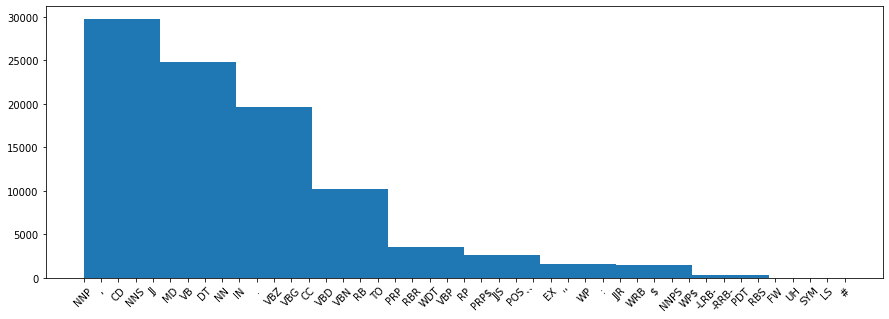

In [13]:
fig=plt.figure(figsize=(15,5))
p = plt.hist(full_dataset["label"])
plt.xticks(rotation=45)
fig.savefig('./report/classes_with_punctuation.png')
fig.show()

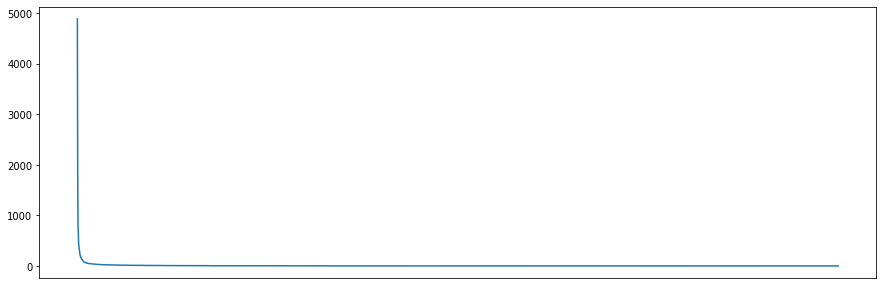

In [14]:
fig=plt.figure(figsize=(15,5))
p = plt.plot(full_dataset["word"].value_counts())
plt.xticks([])
plt.show()

## Data splitting





Creation of train, validation and test sets.

In [15]:
df_train = loadCorpus(1,101) 
df_val = loadCorpus(101,151)
df_test = loadCorpus(151,200)

df_train.count()

word     47356
label    47356
dtype: int64

In [16]:
df_val.count()

word     31183
label    31183
dtype: int64

In [17]:
df_test.count()

word     15545
label    15545
dtype: int64

## Data pre-processing

Clean the data.

In [18]:
def cleanCorpus(corpus):
    # Lower every word    
    corpus['word'] = corpus['word'].str.lower()
    return corpus

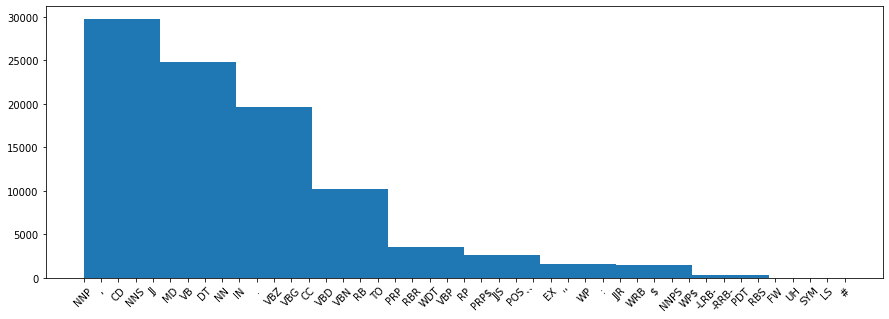

In [19]:
fig=plt.figure(figsize=(15,5))
p = plt.hist(cleanCorpus(full_dataset)["label"])
plt.xticks(rotation=45)
plt.show()

In [20]:
#cleaned dataframes
dfc_train = cleanCorpus(df_train)
dfc_val = cleanCorpus(df_val)
dfc_test = cleanCorpus(df_test)
dfc_sample = cleanCorpus(sample_article)

dfc_train.count()

word     47356
label    47356
dtype: int64

In [21]:
dfc_val.count()

word     31183
label    31183
dtype: int64

In [22]:
dfc_test.count()

word     15545
label    15545
dtype: int64

In [23]:
dfc_train.head(20)

,word,label
0,pierre,NNP
1,vinken,NNP
2,",",","
3,61,CD
4,years,NNS
5,old,JJ
6,",",","
7,will,MD
8,join,VB
9,the,DT


## Word embedding

### Loading GloVe


Loading pre-trained dense word embedding representation: GloVe.






In [24]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [25]:
# Modify these variables as you wish!
# Glove -> 50, 100, 200, 300 (200 seems the better)
# Word2Vec -> 300
# Fasttext -> 300
embedding_dimension = 200
embedding_model = load_embedding_model(model_type="glove", embedding_dimension= embedding_dimension)

[==================================================] 100.0% 252.1/252.1MB downloaded


### Analyzing OOV statistics

In [26]:
embedding_model.index_to_key[0:10]

['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s"]

In [27]:
oov_train = list(set([word for word in dfc_train.word.values if word not in embedding_model.index_to_key]))
oov_val = list(set([word for word in dfc_val.word.values if word not in embedding_model.index_to_key]))
oov_test = list(set([word for word in dfc_test.word.values if word not in embedding_model.index_to_key]))
print(f'oov_train_size: {len(oov_train)}')
print(f'oov_val_size: {len(oov_val)}')
print(f'oov_test_size: {len(oov_test)}')

oov_train_size: 359
oov_val_size: 213
oov_test_size: 161


In [28]:
oov_train[0:10]

['glenham',
 'stock-index',
 'beer-belly',
 '69-point',
 'integra-a',
 'food-shop',
 're-thought',
 'malizia',
 'drag-down',
 'test-preparation']

### GloVe Embedding

#### Prepare the embedding matrix

In [29]:
def deal_OOV(vectors, vocabulary, embedding_dimension, oov_set):
  #deal with oov words by adding a random embedding vector to the embedding matrix
  for idx in range(0, len(oov_set)):
    if oov_set[idx] not in vocabulary:
      vocabulary.append(oov_set[idx])
      #use random embedding for OOV word
      embedding_vector = np.random.uniform(low=-0.05, high=0.05, size= embedding_dimension)
      vectors.append(embedding_vector)
  return vocabulary, vectors

In [30]:
#GloVe vocabulary
words = list(embedding_model.index_to_key)
#extracting the GloVe embedding vectors
vectors = [embedding_model[word] for word in words]
em0 =np.array([0.0]*embedding_dimension)
vectors.insert(0, em0)

#deal with train oov words
vocab, vectors = deal_OOV(vectors, words, embedding_dimension, oov_train)
#deal with validation oov words
vocab, vectors = deal_OOV(vectors, vocab, embedding_dimension, oov_val)
#deal with test oov words
vocab, vectors = deal_OOV(vectors, vocab, embedding_dimension, oov_test)

embedding_matrix = np.asarray(vectors)
print(np.shape(embedding_matrix))


(400677, 200)


Define a tokenizer.

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer

# define the tokenizer, removing the default filters: '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' 
tokenizer = Tokenizer(filters='')
#text = dfc_train.word.values
#fit the tokenizer on the vocabulary of GloVe, including also the OOV words 
tokenizer.fit_on_texts(vocab)

# number of unique words in dict.
print("Number of unique words in dictionary=", len(tokenizer.word_index))
print("Dictionary head: ", dict(list(tokenizer.word_index.items())[0:50]))

Number of unique words in dictionary= 400676
Dictionary head:  {'the': 1, ',': 2, '.': 3, 'of': 4, 'to': 5, 'and': 6, 'in': 7, 'a': 8, '"': 9, "'s": 10, 'for': 11, '-': 12, 'that': 13, 'on': 14, 'is': 15, 'was': 16, 'said': 17, 'with': 18, 'he': 19, 'as': 20, 'it': 21, 'by': 22, 'at': 23, '(': 24, ')': 25, 'from': 26, 'his': 27, "''": 28, '``': 29, 'an': 30, 'be': 31, 'has': 32, 'are': 33, 'have': 34, 'but': 35, 'were': 36, 'not': 37, 'this': 38, 'who': 39, 'they': 40, 'had': 41, 'i': 42, 'which': 43, 'will': 44, 'their': 45, ':': 46, 'or': 47, 'its': 48, 'one': 49, 'after': 50}


In [32]:
"""
from tensorflow.keras.preprocessing.text import Tokenizer

# define the tokenizer
tokenizer = Tokenizer(oov_token='<unk>')
text = dfc_train.word.values

#fit the tokenizer on the training data
tokenizer.fit_on_texts(text)

# number of unique words in dict.
print("Number of unique words in dictionary=", len(tokenizer.word_index))
print("Dictionary head: ", dict(list(tokenizer.word_index.items())[0:10]))
"""

'\nfrom tensorflow.keras.preprocessing.text import Tokenizer\n\n# define the tokenizer\ntokenizer = Tokenizer(oov_token=\'<unk>\')\ntext = dfc_train.word.values\n\n#fit the tokenizer on the training data\ntokenizer.fit_on_texts(text)\n\n# number of unique words in dict.\nprint("Number of unique words in dictionary=", len(tokenizer.word_index))\nprint("Dictionary head: ", dict(list(tokenizer.word_index.items())[0:10]))\n'

In [33]:
with open('./Dataset/word_index.json','w') as word_index_file:
    word_index_file.write(tokenizer.to_json())

Define the embedding matrix.

In [34]:
#remove it after we are sure about the correctness of the embedding done above 
"""
from tqdm import tqdm

def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx,
                           vocab_size: int) -> np.ndarray:
    
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(tokenizer.word_index.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            #print(f"Using random vector for '{word}'")
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix
"""

'\nfrom tqdm import tqdm\n\ndef build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,\n                           embedding_dimension: int,\n                           word_to_idx,\n                           vocab_size: int) -> np.ndarray:\n    \n    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model\n\n    :param embedding_model: pre-trained word embedding model (gensim wrapper)\n    :param word_to_idx: vocabulary map (word -> index) (dict)\n    :param vocab_size: size of the vocabulary\n    \n\n    :return\n        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)\n    \n    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)\n    for word, idx in tqdm(tokenizer.word_index.items()):\n        try:\n            embedding_vector = embedding_model[word]\n        except (KeyError, TypeError):\n            #print(f"Using ra

In [35]:
"""
# Testing
embedding_dimension = 50
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, tokenizer.word_index, vocab_size )
print(f"Embedding matrix shape: {embedding_matrix.shape}")
"""

'\n# Testing\nembedding_dimension = 50\nvocab_size = len(tokenizer.word_index) + 1\nembedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, tokenizer.word_index, vocab_size )\nprint(f"Embedding matrix shape: {embedding_matrix.shape}")\n'

#### Encode the dataset

Define a label encoder for the target class.

In [36]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le = LabelEncoder()
dfc_train['encoded_label'] = le.fit_transform(dfc_train['label'])
dfc_val['encoded_label'] = le.transform(dfc_val['label'])
dfc_test['encoded_label'] = le.transform(dfc_test['label'])
dfc_sample['encoded_label'] = le.transform(dfc_sample['label'])

In [ ]:
df_labels = pd.concat([dfc_train, dfc_val, dfc_test]).drop("word", axis=1)
df_labels = df_labels.drop_duplicates()
df_labels = df_labels.reset_index(drop=True)
df_labels.head()

,label,encoded_label
0,NNP,20
1,",",3
2,CD,9
3,NNS,22
4,JJ,14


In [37]:
dfc_train.head(20)

,word,label,encoded_label
0,pierre,NNP,20
1,vinken,NNP,20
2,",",",",3
3,61,CD,9
4,years,NNS,22
5,old,JJ,14
6,",",",",3
7,will,MD,18
8,join,VB,34
9,the,DT,10


In [38]:
# Filter out punctuation based on the class
# https://universaldependencies.org/docs/en/pos/all.html#al-en-pos/PUNCT
punctuation_classes = [ 
    "``", "’’", "-LRB-", "-RRB-", ",", ".", ":", "HYPH", # PUNCT: punctuation
    "#", "$", "SYM", # SYM: symbol
    "''", # Custom
]

# Select all the unique classes in the dataframe and their encoding
labels = dfc_train.drop_duplicates(['label','encoded_label'])[['label','encoded_label']]

# Extracting the encoded label vector for all punctuation and symbols. Will be used in F1 score calculation   
punctuation_labels = labels[labels.label.isin(punctuation_classes)]['encoded_label'].values

print(f"Punctation labels: {punctuation_labels}")

Punctation labels: [ 3  6 44  2  7  1  4  5 31  0]


Transform the text into a sequence of integers using the tokenizer defined before. 

In [39]:
x_train = np.array(tokenizer.texts_to_sequences(list(dfc_train.word.values))) 
y_train = np.array( dfc_train['encoded_label'])

x_val = np.array(tokenizer.texts_to_sequences(dfc_val.word.values))
y_val = np.array(dfc_val['encoded_label'])

x_test = np.array(tokenizer.texts_to_sequences(dfc_test.word.values))
y_test = np.array(dfc_test['encoded_label'])

x_sample = np.array(tokenizer.texts_to_sequences(dfc_sample.word.values))
y_sample = np.array(dfc_sample['encoded_label'])

#number of unique labels
num_classes = len(np.unique(y_train))
num_classes

45

Pad the sequences to make them of same length before passing them to the model.

In [40]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen=1, padding='post')
x_val = pad_sequences(x_val, maxlen=1, padding='post')
x_test = pad_sequences(x_test, maxlen=1, padding='post')
x_sample = pad_sequences(x_sample, maxlen=1, padding='post')

#Train
print(f'X train shape: {x_train.shape}')
print(f'Y train shape: {y_train.shape}')
print(f'type:{type(x_train)}')

# Val
print(f'X val shape: {x_val.shape}')
print(f'Y val shape: {y_val.shape}')
print(f'type:{type(y_train)}')

# Test
print(f'X test shape: {x_test.shape}', x_test.shape)
print(f'Y test shape: {y_test.shape}', y_test.shape)

X train shape: (47356, 1)
Y train shape: (47356,)
type:<class 'numpy.ndarray'>
X val shape: (31183, 1)
Y val shape: (31183,)
type:<class 'numpy.ndarray'>
X test shape: (15545, 1) (15545, 1)
Y test shape: (15545,) (15545,)


In [41]:
vocab_size = len(tokenizer.word_index) + 1

## Utility methods

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from typing import List, Dict, Callable
import random

In [43]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Set the reproducibility
set_reproducibility(42)

In [44]:
import matplotlib.pyplot as plt
from functools import partial
from keras.callbacks import History

def show_history(history: History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """
    history_data = history.history
    print(f"Displaying the following history keys: {history_data.keys()}")
    
    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if f'val_{key}' in history_data:
                ax.plot(history_data[f'val_{key}'])
            else:
                print(f"Couldn't find validation values for metric: {key}")

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')
            plt.grid(True)
        plt.show()

In [45]:
def train_model(model: keras.Model, training_info: Dict):
    """
    Training routine for the Keras model.
    At the end of the training, retrieved History data is shown.

    :param model: Keras built model
    :param training_info: dictionary storing model fit() argument information

    :return
        model: trained Keras model
    """

    print(f"Start training! \nParameters: {training_info}")

    history = model.fit(x=x_train, y=y_train,
                        validation_data=(x_val, y_val),
                        **training_info)
    print("Training completed!")

    print("Showing history...")
    show_history(history)

    return model

In [46]:
def predict_data(model: keras.Model,
                x: np.ndarray,
                prediction_info: Dict):
    """
    Inference routine of a given input set of examples

    :param model: Keras built and possibly trained model
    :param x: input set of examples in np.ndarray format
    :param prediction_info: dictionary storing model predict() argument information

    :return
        predictions: predicted labels in np.ndarray format
    """
    print(f'Starting prediction: \n{prediction_info}')
    print(f'Predicting on {x.shape[0]} samples')
    predictions = model.predict(x, **prediction_info)
    return predictions

In [47]:
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay

def compute_f1(model: keras.Model, 
             x: np.ndarray, 
             y: np.ndarray,
             get_report: bool = False):
    """
    Compute F1_score on the given data with corresponding labels

    :param model: Keras built and possibly trained model
    :param x: data in np.ndarray format
    :param y: ground-truth labels in np.ndarray format

    :return
        score: f1_macro_score
    """
    #predictions on the x set
    prediction_info = {
        'batch_size': 64,
        'verbose': 1
    }
    
    y_pred = predict_data(model=model, x=x, prediction_info=prediction_info)

    #compute argmax to take the best class for each sample
    y_pred = np.argmax(y_pred, axis=1)
    
    #compute the f1_macro exluding puntuaction labels
    labels = np.unique( np.concatenate((np.unique(y), np.unique(y_pred))))
    labels = [label for label in labels if label not in punctuation_labels]
    
    rep = classification_report(y,y_pred, labels=labels, output_dict=True, zero_division=0)

    # Show confusion matrix
    '''
    cm = confusion_matrix(y,y_pred,labels=labels)
    cm_disp = ConfusionMatrixDisplay(cm,display_labels=labels)
    fig, ax = plt.subplots(figsize=(15,15))
    cm_disp.plot(ax=ax)
    '''
    score = f1_score(y, y_pred, average ='macro', labels=labels)

    if get_report:
        return score, rep
    else: return score

## Baseline model: LSTM

### Define the model

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam


def create_baseline(units, dropout, learning_rate, activation):
    model = keras.Sequential()
    model = keras.models.Sequential()
    
    
    model.add(keras.layers.Embedding(input_dim=vocab_size, 
                                    output_dim = embedding_dimension,
                                    input_length = 1,
                                    weights = [embedding_matrix],
                                    trainable = False))
    
    model.add(keras.layers.Bidirectional(LSTM(units=units, 
                                              activation=activation,
                                              dropout=dropout,
                                              )))

    model.add(keras.layers.Dense(units=num_classes, 
                                 activation="softmax"))

    model.summary()

    model.compile(loss='sparse_categorical_crossentropy', 
                    optimizer=Adam(learning_rate=learning_rate), 
                    metrics=["accuracy"])
    
    return model

#### Using keras tuner to find best hyper parameters

In [49]:
import keras_tuner

def build_baseline(hp):
    units = hp.Int("units", min_value=16, max_value=128, step=16)

    activation = hp.Choice("activation", ["relu", "tanh"])

    dropout = hp.Float("dropout", min_value=0, max_value=0.2, step=0.05)

    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = create_baseline(units=units, 
                            activation=activation, 
                            dropout=dropout, 
                            learning_rate=learning_rate
                        )
    return model

In [50]:
if not os.path.exists("./models"):
    os.makedirs("./models")

tuner = keras_tuner.Hyperband(hypermodel=build_baseline,
                            objective='accuracy',
                            max_epochs=30,
                            factor=3,
                            directory='./models',
                            project_name='baseline')
tuner.search_space_summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 200)            80135400  
                                                                 
 bidirectional (Bidirectiona  (None, 32)               27776     
 l)                                                              
                                                                 
 dense (Dense)               (None, 45)                1485      
                                                                 
Total params: 80,164,661
Trainable params: 29,261
Non-trainable params: 80,135,400
_________________________________________________________________
Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['re

In [51]:
# Search the best hyper-parameter and select the best model
'''
tuner.search(x_train,y_train, epochs=30, validation_data=(x_val,y_val))
best_model = tuner.get_best_models()[0]
tuner.results_summary()
'''

'\ntuner.search(x_train,y_train, epochs=30, validation_data=(x_val,y_val))\nbest_model = tuner.get_best_models()[0]\ntuner.results_summary()\n'

Hyperparameters:
* units: 32
* activation: tanh
* dropout: 0
* learning_rate: 0.0028081
* tuner/epochs: 30
* tuner/initial_epoch: 10

Score: 0.9271686673164368

In [52]:
# Create model with best hyperparameter 
base_model = create_baseline(units= 32,
                            activation="tanh",
                            dropout=0,
                            learning_rate=0.0028081)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1, 200)            80135400  
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               59648     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 45)                2925      
                                                                 
Total params: 80,197,973
Trainable params: 62,573
Non-trainable params: 80,135,400
_________________________________________________________________


Start training! 
Parameters: {'verbose': 0, 'epochs': 30, 'batch_size': 64, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7ff095565a00>]}
Restoring model weights from the end of the best epoch: 9.
Epoch 14: early stopping
Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


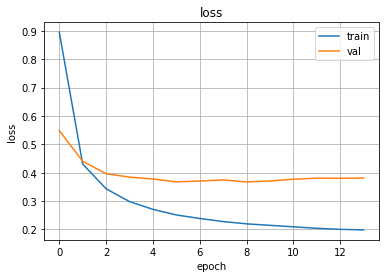

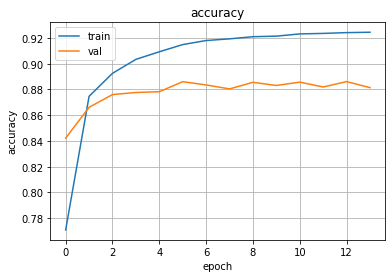

In [53]:
# Train
base_training_info = {
    'verbose': 0,
    'epochs' : 30,
    'batch_size' : 64,
    'callbacks' : [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                    patience=5,
                                                    verbose=1,
                                                    mode="auto",
                                                    baseline=None,
                                                    restore_best_weights=True)]
}

base_model = train_model(model=base_model,training_info = base_training_info)

#### F1-Macro evaluation

In [54]:
loss, accuracy = base_model.evaluate(x_val, y_val)
print(f"Model loss: {loss}, accuracy: {accuracy}")

# Inference and evaluate

# The report is going to be used in the conclusions to discuss errors

base_score, report = compute_f1(base_model, x_val, y_val, get_report=True)
print(f'F1_score on the validation set is: {base_score}')


975/975 [==============================] - 3s 3ms/step - loss: 0.3673 - accuracy: 0.8856
Model loss: 0.3672676980495453, accuracy: 0.8855786919593811
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 31183 samples
488/488 [==============================] - 2s 2ms/step
F1_score on the validation set is: 0.7070001736001936


#### Sample test

In [55]:
x_sample_text = tokenizer.sequences_to_texts(x_sample)
y_pred_sample_onehot = base_model.predict(x_sample)
y_pred_sample = np.argmax(y_pred_sample_onehot, axis=1)
for i in range(x_sample.size):
    print(f"{y_pred_sample[i]} \t {y_sample[i]} \t {'ok' if y_pred_sample[i]==y_sample[i] else 'ERR'} \t {x_sample_text[i]}")

1/1 [==============================] - 0s 23ms/step
20 	 20 	 ok 	 pierre
14 	 20 	 ERR 	 vinken
3 	 3 	 ok 	 ,
9 	 9 	 ok 	 61
22 	 22 	 ok 	 years
14 	 14 	 ok 	 old
3 	 3 	 ok 	 ,
18 	 18 	 ok 	 will
34 	 34 	 ok 	 join
10 	 10 	 ok 	 the
19 	 19 	 ok 	 board
13 	 13 	 ok 	 as
10 	 10 	 ok 	 a
14 	 14 	 ok 	 nonexecutive
19 	 19 	 ok 	 director
20 	 20 	 ok 	 nov.
9 	 9 	 ok 	 29
6 	 6 	 ok 	 .
20 	 20 	 ok 	 mr.
14 	 20 	 ERR 	 vinken
39 	 39 	 ok 	 is
19 	 19 	 ok 	 chairman
13 	 13 	 ok 	 of
20 	 20 	 ok 	 elsevier
20 	 20 	 ok 	 n.v.
3 	 3 	 ok 	 ,
10 	 10 	 ok 	 the
20 	 20 	 ok 	 dutch
20 	 36 	 ERR 	 publishing
20 	 19 	 ERR 	 group
6 	 6 	 ok 	 .


## Model A: GRU

GRU is a simpler alternative to LSTM's architecture, less effective but with a faster train.
</br>Two layers architecture: a Bidirectional GRU layer and a Dense/FC layer on top. 

In [56]:
# Create model

def create_gru(units, dropout, learning_rate, activation):
    model = keras.Sequential()
    model = keras.models.Sequential()
    
    
    model.add(keras.layers.Embedding(input_dim=vocab_size, 
                                    output_dim = embedding_dimension,
                                    input_length = 1,
                                    weights = [embedding_matrix],
                                    trainable = False))
    
    model.add(keras.layers.Bidirectional(GRU(units=units, 
                                              activation=activation,
                                              dropout=dropout,
                                              )))

    model.add(keras.layers.Dense(units=num_classes, 
                                 activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", 
                    optimizer=Adam(learning_rate=learning_rate), 
                    metrics=["accuracy"])
    
    return model

In [57]:
def build_GRU(hp):
    units = hp.Int("units", min_value=16, max_value=256, step=16)

    activation = hp.Choice("activation", ["relu", "tanh"])

    dropout = hp.Float("dropout", min_value=0, max_value=0.2, step=0.05)

    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = create_gru(units=units, 
                            activation=activation, 
                            dropout=dropout, 
                            learning_rate=learning_rate
                        )
    return model

In [58]:
tuner = keras_tuner.Hyperband(hypermodel=build_GRU,
                            objective='accuracy',
                            max_epochs=30,
                            factor=3,
                            directory='a1models',
                            project_name='GRU')
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.2, 'step': 0.05, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [59]:
# Search the best hyper-parameter and select the best model
'''
tuner.search(x_train,y_train, epochs=30, validation_data=(x_val,y_val))
best_model = tuner.get_best_models()[0]
tuner.results_summary()
'''

'\ntuner.search(x_train,y_train, epochs=30, validation_data=(x_val,y_val))\nbest_model = tuner.get_best_models()[0]\ntuner.results_summary()\n'

Hyperparameters:
* units: 112
* activation: tanh
* dropout: 0.05
* learning_rate: 0.000642144054857491
* tuner/epochs: 15
  
Score: 0.9216994643211365

In [60]:
# Create model with best hyperparameter 
gru_model = create_gru(units= 112,
                            activation="tanh",
                            dropout=0.05,
                            learning_rate=0.000642144054857491,
                            )

Start training! 
Parameters: {'verbose': 0, 'epochs': 30, 'batch_size': 64, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7ff03245ee50>]}
Restoring model weights from the end of the best epoch: 17.
Epoch 22: early stopping
Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


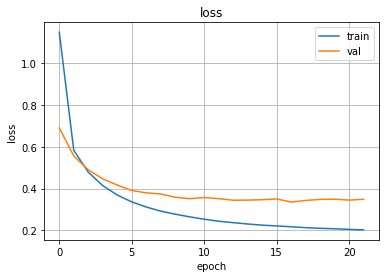

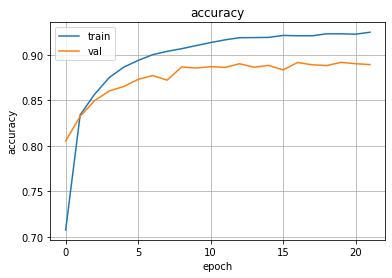

In [61]:
# Train
gru_training_info = {
    'verbose': 0,
    'epochs' : 30,
    'batch_size' : 64,
    'callbacks' : [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                patience=5,
                                                verbose=1,
                                                mode="auto",
                                                baseline=None,
                                                restore_best_weights=True)]
}

gru_model = train_model(model=gru_model,training_info = gru_training_info)

#### F1-Macro evaluation

In [62]:
loss, accuracy = gru_model.evaluate(x_val, y_val)
print(f"Model loss: {loss}, accuracy: {accuracy}")

# Inference and evaluate

gru_score = compute_f1(gru_model, x_val, y_val)
print(f'F1_score on the validation set is: {gru_score}')

975/975 [==============================] - 3s 3ms/step - loss: 0.3360 - accuracy: 0.8916
Model loss: 0.336009681224823, accuracy: 0.8916075825691223
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 31183 samples
488/488 [==============================] - 2s 2ms/step
F1_score on the validation set is: 0.7017482531269984


## Model B: 2x LSTM + Dense 

In [63]:
# Create model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam

def create_2xlstm(lstm1_units, lstm2_units, lstm1_dropout, lstm2_dropout, learning_rate, lstm1_activation, lstm2_activation):
    model = keras.Sequential()
    model = keras.models.Sequential()
    
    
    model.add(keras.layers.Embedding(input_dim=vocab_size, 
                                    output_dim = embedding_dimension,
                                    input_length = 1,
                                    weights = [embedding_matrix],
                                    trainable = False))
    
    model.add(keras.layers.Bidirectional(LSTM(units=lstm1_units,
                                              dropout=lstm1_dropout,
                                              activation=lstm1_activation,
                                              return_sequences=True
                                              )))
    
    model.add(keras.layers.Bidirectional(LSTM(units=lstm2_units,
                                              dropout=lstm2_dropout,
                                              activation=lstm2_activation
                                              )))

    model.add(keras.layers.Dense(units=num_classes, 
                                 activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", 
                    optimizer=Adam(learning_rate=learning_rate), 
                    metrics=["accuracy"])
    
    return model

In [64]:
def build_2xLSTM(hp):
    lstm1_units = hp.Int("lstm1_units", min_value=16, max_value=128, step=16)
    lstm2_units = hp.Int("lstm2_units", min_value=16, max_value=128, step=16)

    lstm1_activation = hp.Choice("lstm1_activation", ["relu", "tanh"])
    lstm2_activation = hp.Choice("lstm2_activation", ["relu", "tanh"])

    lstm1_dropout = hp.Float("lstm1_dropout", min_value=0, max_value=0.4, step=0.1)
    lstm2_dropout = hp.Float("lstm2_dropout", min_value=0, max_value=0.4, step=0.1)

    learning_rate = hp.Float("learning_rate", min_value=1e-3, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = create_2xlstm(lstm1_units=lstm1_units,
                            lstm2_units=lstm2_units, 
                            lstm1_activation=lstm1_activation, 
                            lstm2_activation=lstm2_activation,
                            lstm1_dropout=lstm1_dropout,
                            lstm2_dropout=lstm2_dropout,
                            learning_rate=learning_rate
                        )
    return model

In [65]:
tuner = keras_tuner.Hyperband(hypermodel=build_2xLSTM,
                            objective='accuracy',
                            max_epochs=30,
                            factor=3,
                            directory='models',
                            project_name='2xLSTM')
tuner.search_space_summary()

Search space summary
Default search space size: 7
lstm1_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
lstm2_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
lstm1_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
lstm2_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
lstm1_dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
lstm2_dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [66]:
# Search the best hyper-parameter and select the best model
"""
tuner.search(x_train,y_train, epochs=30, validation_data=(x_val,y_val),
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                        min_delta=0.015,
                                                                        patience=3,
                                                                        verbose=0,
                                                                        mode="auto",
                                                                        baseline=None,
                                                                        restore_best_weights=True)])
best_model = tuner.get_best_models()[0]
tuner.results_summary()
"""

'\ntuner.search(x_train,y_train, epochs=30, validation_data=(x_val,y_val),\n                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",\n                                                                        min_delta=0.015,\n                                                                        patience=3,\n                                                                        verbose=0,\n                                                                        mode="auto",\n                                                                        baseline=None,\n                                                                        restore_best_weights=True)])\nbest_model = tuner.get_best_models()[0]\ntuner.results_summary()\n'

Hyperparameters:
* LSTM1_units: 128
* LSTM2_units: 112
* LSTM1_activation: tanh
* LSTM2_activation: relu
* LSTM1_dropout: 0.0
* LSTM2_dropout: 0.2
* learning_rate: 0.0014114864841283698
* tuner/epochs: 10
  
Score: 0.9165892601013184

In [67]:
# Create model with best hyperparameter 
LSTMx2_model = create_2xlstm(lstm1_units=128,
                                    lstm2_units=112,
                                    lstm1_activation="tanh",
                                    lstm2_activation="relu",
                                    lstm1_dropout=0.2,
                                    lstm2_dropout=0.0,
                                    learning_rate=0.0014114864841283698) 

Start training! 
Parameters: {'verbose': 0, 'epochs': 30, 'batch_size': 64, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7ff0a1dbd070>]}
Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping
Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


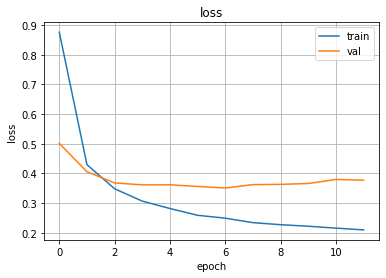

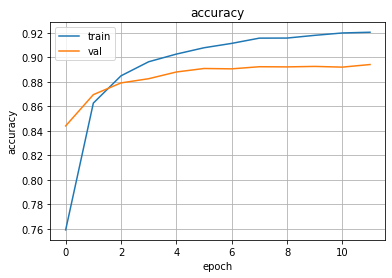

In [68]:
# Train
LSTMx2_training_info = {
    'verbose': 0,
    'epochs' : 30,
    'batch_size' : 64,
    'callbacks' : [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                    min_delta=0.0,
                                                    patience=5,
                                                    verbose=1,
                                                    mode="auto",
                                                    baseline=None,
                                                    restore_best_weights=True)]
}

LSTMx2_model = train_model(model=LSTMx2_model,training_info = LSTMx2_training_info)

#### F1-Macro evaluation

In [69]:
loss, accuracy = LSTMx2_model.evaluate(x_val, y_val)
print(f"Model loss: {loss}, accuracy: {accuracy}")

# Inference and evaluate

LSTMx2_score = compute_f1(LSTMx2_model, x_val, y_val)
print(f'F1_score on the validation set is: {LSTMx2_score}')

975/975 [==============================] - 4s 4ms/step - loss: 0.3509 - accuracy: 0.8906
Model loss: 0.3509283661842346, accuracy: 0.8905814290046692
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 31183 samples
488/488 [==============================] - 2s 3ms/step
F1_score on the validation set is: 0.7081405787278162


## Model C: LSTM + 2x Dense

In [70]:
# Create model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam

def create_lstm_dense(lstm_units, dense_units, lstm_dropout, learning_rate, lstm_activation, dense_activation):
    model = keras.Sequential()
    model = keras.models.Sequential()
    
    
    model.add(keras.layers.Embedding(input_dim=vocab_size, 
                                    output_dim = embedding_dimension,
                                    input_length = 1,
                                    weights = [embedding_matrix],
                                    trainable = False))
    
    model.add(keras.layers.Bidirectional(LSTM(units=lstm_units,
                                              dropout=lstm_dropout,
                                              activation=lstm_activation
                                              )))

    model.add(keras.layers.Dense(units=dense_units, 
                                 activation=dense_activation))


    model.add(keras.layers.Dense(units=num_classes, 
                                 activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", 
                    optimizer=Adam(learning_rate=learning_rate), 
                    metrics=["accuracy"])
    
    return model
    

In [71]:
def build_LSTM_Dense(hp):
    lstm_units = hp.Int("lstm_units", min_value=16, max_value=128, step=16)
    dense_units = hp.Int("dense_units", min_value=16, max_value=128, step=16)

    lstm_activation = hp.Choice("lstm_activation", ["relu", "tanh"])
    dense_activation = hp.Choice("dense_activation", ["relu", "tanh"])

    lstm_dropout = hp.Float("lstm_dropout", min_value=0, max_value=0.4, step=0.1)

    learning_rate = hp.Float("learning_rate", min_value=1e-3, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = create_lstm_dense(lstm_units=lstm_units,
                            dense_units=dense_units, 
                            lstm_activation=lstm_activation, 
                            dense_activation=dense_activation,
                            lstm_dropout=lstm_dropout,
                            learning_rate=learning_rate
                        )
    return model

In [72]:
tuner = keras_tuner.Hyperband(hypermodel=build_LSTM_Dense,
                            objective='accuracy',
                            max_epochs=30,
                            factor=3,
                            directory='./models',
                            project_name='LSTM_DENSE2')
tuner.search_space_summary()

Search space summary
Default search space size: 6
lstm_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
lstm_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
lstm_dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [73]:
# Search the best hyper-parameter and select the best model
# The Early stopping callback with a min_delta is setted to improve the performance
'''
tuner.search(x_train,y_train, epochs=30, validation_data=(x_val,y_val),
                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                        min_delta=0.015,
                                                                        patience=3,
                                                                        verbose=0,
                                                                        mode="auto",
                                                                        baseline=None,
                                                                        restore_best_weights=True)])
best_model = tuner.get_best_models()[0]
tuner.results_summary()
'''


'\ntuner.search(x_train,y_train, epochs=30, validation_data=(x_val,y_val),\n                            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",\n                                                                        min_delta=0.015,\n                                                                        patience=3,\n                                                                        verbose=0,\n                                                                        mode="auto",\n                                                                        baseline=None,\n                                                                        restore_best_weights=True)])\nbest_model = tuner.get_best_models()[0]\ntuner.results_summary()\n'

Hyperparameters:
* LSTM_units: 112
* LSTM_activation: relu
* Dense_units: 64
* Dense_activation: tanh
* dropout: 0.0
* learning_rate: 0.001209925672797829
* tuner/epochs: 30
  
Score: 0.9195877909660339

In [74]:
# Create model with best hyperparameter 
lstm_dense_model = create_lstm_dense(lstm_units=112,
                                    dense_units=64,
                                    lstm_activation="relu",
                                    dense_activation="tanh",
                                    lstm_dropout=0.0,
                                    learning_rate=0.001209925672797829) 

Start training! 
Parameters: {'verbose': 0, 'epochs': 30, 'batch_size': 64, 'callbacks': [<keras.callbacks.EarlyStopping object at 0x7ff02a047df0>]}
Restoring model weights from the end of the best epoch: 6.
Epoch 11: early stopping
Training completed!
Showing history...
Displaying the following history keys: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


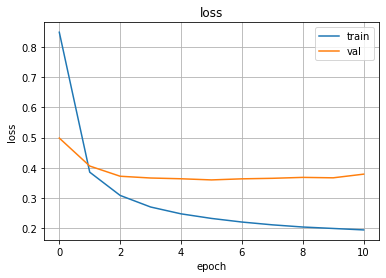

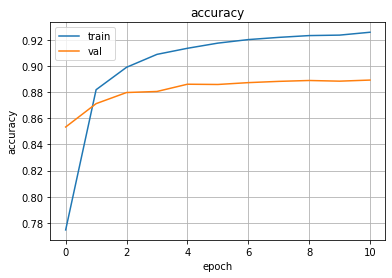

In [75]:
# Train
lstm_dense_training_info = {
    'verbose': 0,
    'epochs' : 30,
    'batch_size' : 64,
    'callbacks' : [tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                    patience=5,
                                                    verbose=1,
                                                    mode="auto",
                                                    baseline=None,
                                                    restore_best_weights=True)]
}

lstm_dense_model = train_model(model=lstm_dense_model,training_info = lstm_dense_training_info)

#### F1-Macro evaluation

In [76]:
loss, accuracy = lstm_dense_model.evaluate(x_val, y_val)
print(f"Model loss: {loss}, accuracy: {accuracy}")

# Inference and evaluate

lstm_dense_score = compute_f1(lstm_dense_model, x_val, y_val)
print(f'F1_score on the validation set is: {lstm_dense_score}')



975/975 [==============================] - 3s 3ms/step - loss: 0.3597 - accuracy: 0.8858
Model loss: 0.35968634486198425, accuracy: 0.8858352303504944
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 31183 samples
488/488 [==============================] - 1s 2ms/step
F1_score on the validation set is: 0.716422434973823


## Summary

In [78]:
print(f''' 
F1 Macro scores on the validation set:
    Bi-LSTM + Dense = {base_score}
    Bi-GRU + Dense = {gru_score}
    2x Bi-LSTM + Dense = {LSTMx2_score}
    Bi-LSTM + 2x Dense = {lstm_dense_score}
''')

 
F1 Macro scores on the validation set:
    Bi-LSTM + Dense = 0.7070001736001936
    Bi-GRU + Dense = 0.7017482531269984
    2x Bi-LSTM + Dense = 0.7081405787278162
    Bi-LSTM + 2x Dense = 0.716422434973823



2xBi-LSTM and Bi-LSTM + 2xDense result to be the bests on the validation set.

F1-Score on the test set 

In [81]:
test_lstmx2_score = compute_f1(LSTMx2_model, x_test, y_test)
test_lstm_dense_score = compute_f1(lstm_dense_model, x_test, y_test)

Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 15545 samples
243/243 [==============================] - 1s 5ms/step
Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 15545 samples
243/243 [==============================] - 1s 3ms/step


In [82]:
print(f''' 
F1 Macro scores on the test set:
    2xBi-LSTM + Dense = {test_lstmx2_score}
    Bi-LSTM + 2x Dense = {test_lstm_dense_score}
''')

 
F1 Macro scores on the test set:
    2xBi-LSTM + Dense = 0.7824798223045395
    Bi-LSTM + 2x Dense = 0.7937497325596763



### Error analysis 

Both the models have a better performance on the test set respect to the validation. Let's see the scores for each class, focusing on the class distribution in the different sets

In [ ]:
val_not_test_labels = [label for label in dfc_val['label'].drop_duplicates().values if label not in dfc_test['label'].drop_duplicates().values ]
test_not_val_labels = [label for label in dfc_test['label'].drop_duplicates().values if label not in dfc_val['label'].drop_duplicates().values ]

print(f"Labels in the validation set that are not in the test set: \n{val_not_test_labels}")
print(f"Labels in the test set that are not in the validation set: \n{test_not_val_labels}")

Labels in the validation set that are not in the test set: 
['FW', 'UH', '#', 'LS']
Labels in the test set that are not in the validation set: 
[]


The validation set is a well representation of the test set, including all of its classes.

There are few labels that are not present in the test set.

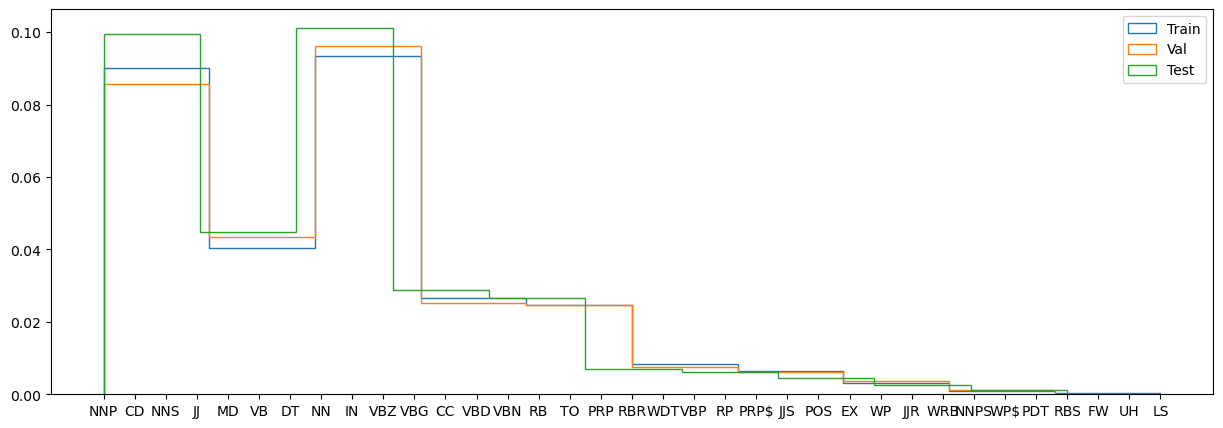

In [ ]:
# Class distribution in the sets, normalized.

plt.figure(figsize=(15,5))
plt.hist(dfc_train[~dfc_train["label"].isin(punctuation_classes)].label, 
#plt.hist(dfc_train.label, 
                density=True,
                label="Train",
                histtype="step",
                )
plt.hist(dfc_val[~dfc_val["label"].isin(punctuation_classes)].label, 
#plt.hist(dfc_val.label, 
                density=True,
                label="Val",
                histtype="step",
                )

plt.hist(dfc_test[~dfc_test["label"].isin(punctuation_classes)].label, 
#plt.hist(dfc_test.label, 
                density=True,
                label="Test",
                histtype="step",
                )

plt.legend()
plt.show()

In [ ]:
# Get a dataframe from the report, obtained from base line model
df_report = pd.DataFrame.from_records(report).transpose()

# Add encoded_labels to the report doing a merge, drop not label rows
df_report['encoded_label'] = df_report.index
df_report = df_report[df_report[['encoded_label']].apply(lambda x: x[0].isdigit(), axis=1)]
df_report['encoded_label'] = pd.to_numeric(df_report['encoded_label'])
df_report.reset_index(drop=True, inplace=True)

df_rep_encod = pd.merge(left=df_report, right=df_labels, how="inner", on = "encoded_label")
df_rep_encod.drop(["precision", "recall"], axis=1, inplace=True) 
print(df_rep_encod.head())



   f1-score  support  encoded_label label
0  0.988522   2754.0             10    DT
1  0.944444     34.0             11    EX
2  0.000000      2.0             12    FW
3  0.967422   3275.0             13    IN
4  0.731600   1924.0             14    JJ


/tmp/ipykernel_6968/3410328708.py:5: FutureWarning: `sort_columns` is deprecated and will be removed in a future version.
  df_rep_encod.plot(x="label", y="f1-score", kind="bar", sort_columns=True)


<Figure size 1500x200 with 0 Axes>

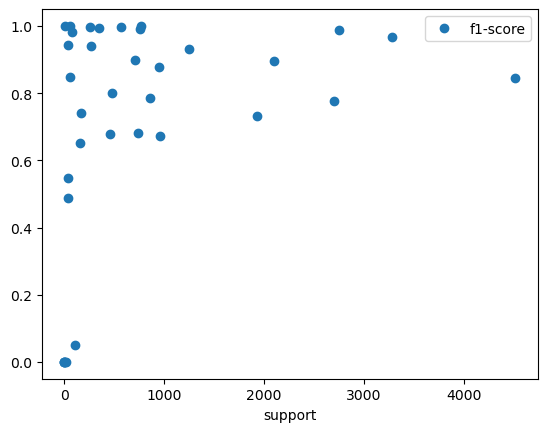

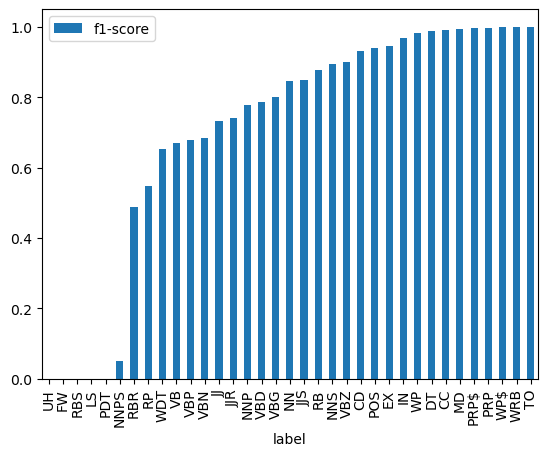

In [ ]:
# Plot 
plt.figure(figsize=(15,2))
df_rep_encod.plot(x="support", y="f1-score", style="o")
df_rep_encod.sort_values("f1-score", inplace= True)
df_rep_encod.plot(x="label", y="f1-score", kind="bar", sort_columns=True)
plt.show()

The f1 score is not support related, there are example with few istances with high f1 score, and viceversa.

Without considering the # label, not considered in the evaluation, it's possible to see that the classes UH, FW and LS, which are present in the validation set but not in the test set, are the ones with a null F1-score, decreasing the average.

   f1-score   support  encoded_label label
0  0.988522  0.610064             10    DT
1  0.944444  0.007094             11    EX
2  0.000000  0.000000             12    FW
3  0.967422  0.725560             13    IN
4  0.731600  0.426070             14    JJ
The classes not present in the test set but in the validation
word             7
label            7
encoded_label    7
dtype: int64


<Figure size 1500x500 with 0 Axes>

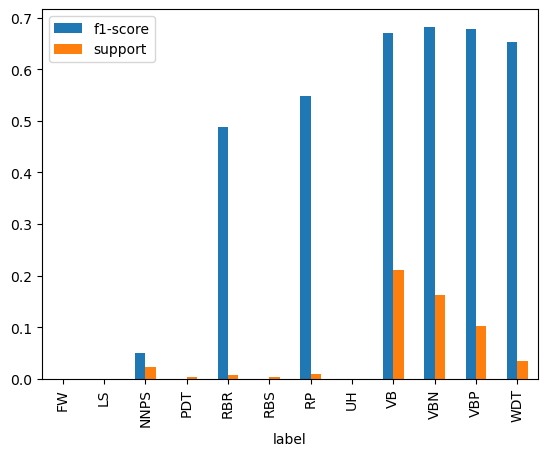

In [ ]:
dfc_val_labels = dfc_val[~dfc_val["label"].isin(punctuation_classes)]
plt.figure(figsize=(15,5))


df_rep_encod['support'] = (df_rep_encod['support'] - df_rep_encod['support'].min())/(df_rep_encod['support'].max()-df_rep_encod['support'].min()) 
print(df_rep_encod.head())

# Plot the F1 score and the normalized label's count (support) with a threshold
df_rep_encod[df_rep_encod["f1-score"] <= 0.7].plot(x="label", y=["f1-score", "support"], kind="bar")

# Count the classes only present in the validation
count_label_val_notest = dfc_val_test = dfc_val_labels[dfc_val_labels["label"].isin(val_not_test_labels)].count()
print(f"The classes not present in the test set but in the validation\n{count_label_val_notest}")

It is possible to observe that UH, LS and FW, cointaned in the validation but not in the test have a null f1-score even with a few example (7), decreasing the average by a lot.

To be complete, let's test the base line with the test set and see if there are important variation on f1 score of each class

In [ ]:
base_score_test, report_test = compute_f1(base_model, x_test, y_test, get_report=True)
print(f'F1_score on the validation set is: {base_score_test}')


Starting prediction: 
{'batch_size': 64, 'verbose': 1}
Predicting on 15545 samples
243/243 [==============================] - 0s 913us/step
F1_score on the validation set is: 0.7829957538609086


In [ ]:
# Get a dataframe from the report, obtained from base line model
df_report_test = pd.DataFrame.from_records(report_test).transpose()

df_report_test['encoded_label'] = df_report_test.index
df_report_test = df_report_test[df_report_test[['encoded_label']].apply(lambda x: x[0].isdigit(), axis=1)]
df_report_test['encoded_label'] = pd.to_numeric(df_report_test['encoded_label'])
df_report_test.reset_index(drop=True, inplace=True)

df_rep_encod_test = pd.merge(left=df_report_test, right=df_labels, how="inner", on = "encoded_label")
df_rep_encod_test.drop(["precision", "recall"], axis=1, inplace=True) 

print(df_rep_encod_test.head())


   f1-score  support  encoded_label label
0  0.987961   1335.0             10    DT
1  0.909091      5.0             11    EX
2  0.969642   1630.0             13    IN
3  0.734592    918.0             14    JJ
4  0.788462     59.0             15   JJR


In [ ]:
df_rep_encod_test['support'] = (df_rep_encod_test['support'] - df_rep_encod_test['support'].min())/(df_rep_encod_test['support'].max()-df_rep_encod_test['support'].min()) 

   f1-score val  support val  encoded_label label  f1-score test  support test
0      0.987961     0.559664             10    DT       0.988522      0.610064
1      0.909091     0.000840             11    EX       0.944444      0.007094
2      0.969642     0.683613             13    IN       0.967422      0.725560
3      0.734592     0.384454             14    JJ       0.731600      0.426070
4      0.788462     0.023529             15   JJR       0.740741      0.036134


<AxesSubplot: xlabel='label'>

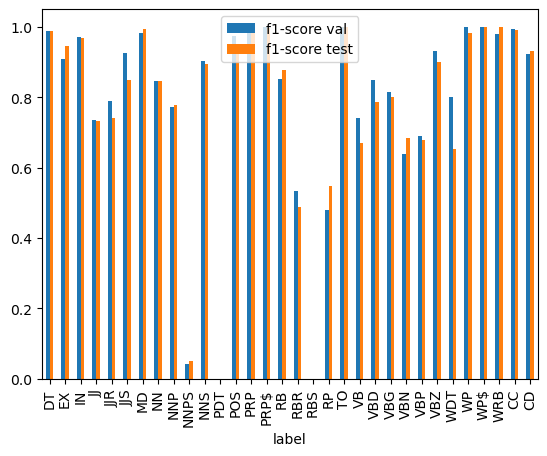

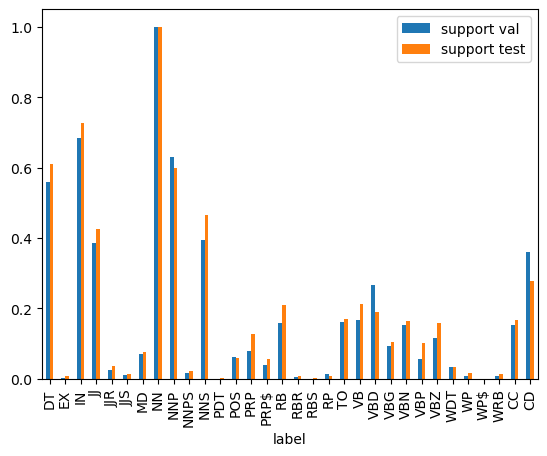

In [ ]:
df_full_report = pd.merge(right=df_rep_encod,  
                            left=df_rep_encod_test,
                            suffixes=[" val"," test"],
                            how="inner", 
                            on=["encoded_label","label"])
print(df_full_report.head())
df_full_report.plot(x="label", y=["f1-score val", "f1-score test"], kind="bar")
df_full_report.plot(x="label", y=["support val", "support test"], kind="bar")


F1 score compared between validation and test it's similar for every label, except for a few variations.